Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ RF raw crops generated
Feature shape: (3579, 4096)
✔ Random Forest trained & saved
Random Forest (Raw Pixels) Accuracy (%): 83.2183908045977
Random Forest (Raw Pixels) Precision (%): 85.09796087442011
Random Forest (Raw Pixels) Recall (%): 80.96748371088034


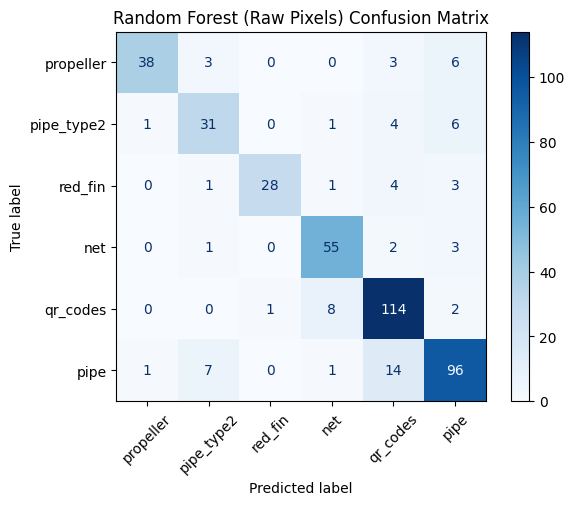

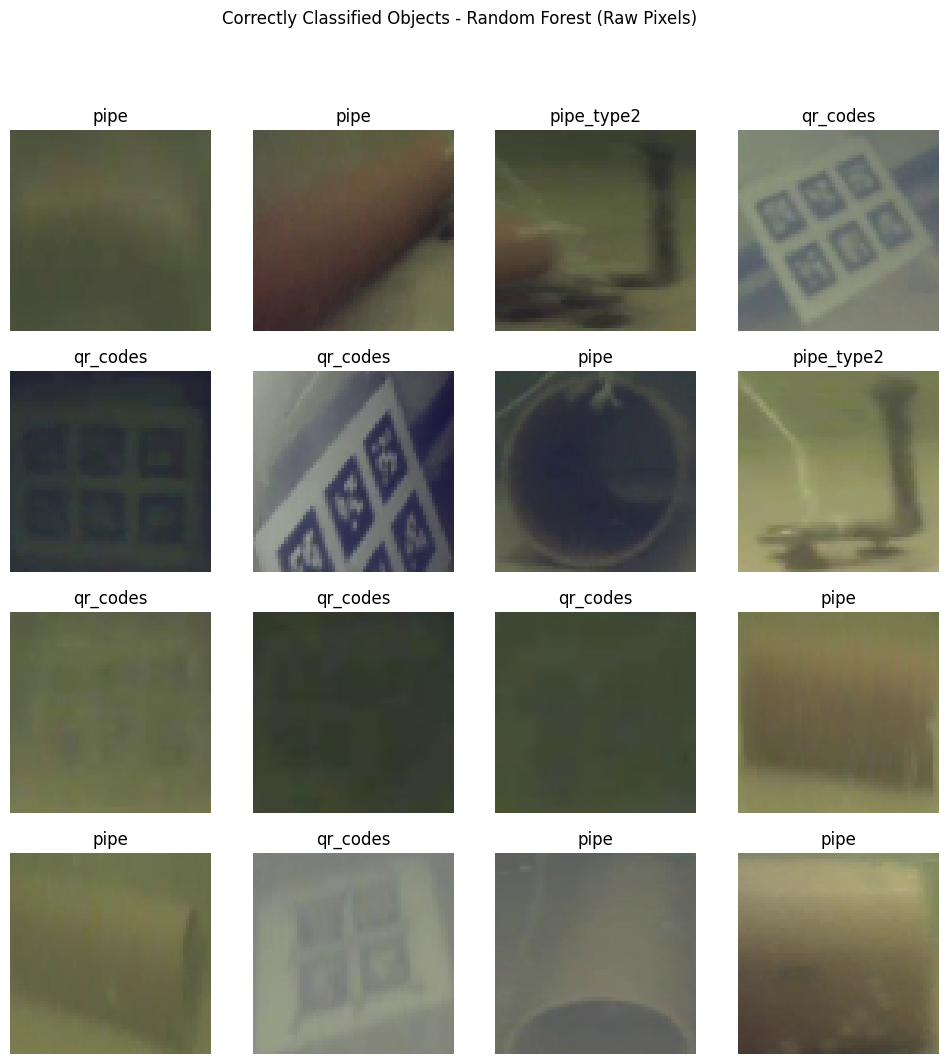

In [ ]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

# --- Paths and classes ---
BASE_PATH = "/content/drive/My Drive/Colab Notebooks/Thesis_Dataset/Dataset1"
TRAIN_IMG = f"{BASE_PATH}/train/images"
TRAIN_LBL = f"{BASE_PATH}/train/labels"
TEST_IMG  = f"{BASE_PATH}/test/images"
TEST_LBL  = f"{BASE_PATH}/test/labels"
CROP_DIR  = "/content/rf_raw_crops"
MODEL_PATH = "/content/rf_raw_model.joblib"

CLASSES = ["propeller", "pipe_type2", "red_fin", "net", "qr_codes", "pipe"]

# --- Helper function: YOLO label → crop ---
def yolo_to_crop(img, line):
    h, w = img.shape[:2]
    cls, x, y, bw, bh = map(float, line.split())
    x1 = int((x - bw/2) * w)
    y1 = int((y - bh/2) * h)
    x2 = int((x + bw/2) * w)
    y2 = int((y + bh/2) * h)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    return int(cls), img[y1:y2, x1:x2]

# --- Step 1: Generate crops ---
os.makedirs(CROP_DIR, exist_ok=True)
for cls in CLASSES:
    os.makedirs(f"{CROP_DIR}/{cls}", exist_ok=True)

for img_name in os.listdir(TRAIN_IMG):
    img_path = f"{TRAIN_IMG}/{img_name}"
    lbl_path = f"{TRAIN_LBL}/{img_name.replace('.jpg','.txt')}"
    if not os.path.exists(lbl_path): continue

    img = cv2.imread(img_path)
    with open(lbl_path) as f:
        for i, line in enumerate(f):
            cls_id, crop = yolo_to_crop(img, line)
            if crop.size == 0: continue
            crop = cv2.resize(crop, (64, 64))
            cv2.imwrite(f"{CROP_DIR}/{CLASSES[cls_id]}/{img_name[:-4]}_{i}.jpg", crop)

print("✔ RF raw crops generated")

# --- Step 2: Feature extraction (RAW PIXELS) ---
X, y = [], []

for cls_id, cls in enumerate(CLASSES):
    cls_path = f"{CROP_DIR}/{cls}"
    for img_name in os.listdir(cls_path):
        img = cv2.imread(f"{cls_path}/{img_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # grayscale for simplicity
        img = img / 255.0                            # normalize
        feat = img.flatten()                         # raw pixel vector
        X.append(feat)
        y.append(cls_id)

X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)

# --- Step 3: Train Random Forest ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X, y)
joblib.dump(rf, MODEL_PATH)
print("✔ Random Forest trained & saved")

# --- Step 4: Test + metrics + visualization ---
rf = joblib.load(MODEL_PATH)

y_true, y_pred = [], []
correct_images = []

for img_name in os.listdir(TEST_IMG):
    img_path = f"{TEST_IMG}/{img_name}"
    lbl_path = f"{TEST_LBL}/{img_name.replace('.jpg','.txt')}"
    if not os.path.exists(lbl_path): continue

    img = cv2.imread(img_path)
    with open(lbl_path) as f:
        for line in f:
            cls_id, crop = yolo_to_crop(img, line)
            if crop.size == 0: continue

            crop = cv2.resize(crop, (64,64))
            gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
            gray = gray / 255.0
            feat = gray.flatten()

            pred = rf.predict([feat])[0]

            y_true.append(cls_id)
            y_pred.append(pred)

            if pred == cls_id:
                correct_images.append((crop, CLASSES[pred]))

# --- Step 5: Metrics ---
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec  = recall_score(y_true, y_pred, average="macro")

print("Random Forest (Raw Pixels) Accuracy (%):", acc * 100)
print("Random Forest (Raw Pixels) Precision (%):", prec * 100)
print("Random Forest (Raw Pixels) Recall (%):", rec * 100)

# --- Step 6: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Random Forest (Raw Pixels) Confusion Matrix")
plt.show()

# --- Step 7: Show correctly classified crops ---
plt.figure(figsize=(12,12))
for i, (crop, label) in enumerate(correct_images[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')

plt.suptitle("Correctly Classified Objects - Random Forest (Raw Pixels)")
plt.show()
